# Milestone 1
Unsupervised learning and data analysis.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import sklearn.preprocessing

In [2]:
df = pd.read_csv('dengue_features_train.csv')

## Filter data for group subset
Our group is working on dataset San Juan 1992-98

In [3]:
df['city'].value_counts()

sj    936
iq    520
Name: city, dtype: int64

In [4]:
#criteria = (df['city'].values == 'sj', df['year'].values >= 1992, df['year'].values <= 1998)
#df = df[np.sum(criteria, axis=0, dtype=np.int8) == 3]
df = df[df['city'] == 'sj']
df = df[df['year'] >= 1992]
df = df[df['year'] <= 1998]

In [5]:
df.drop(['city', 'year', 'weekofyear', 'week_start_date'], axis=1, inplace=True)
df.shape

(364, 20)

In [6]:
df.head()

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
87,0.125100,0.157867,0.185283,0.181367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,0.100833,0.073575,0.138714,0.112786,200.85,297.912857,298.121429,294.457143,300.4,296.1,18.30,81.300000,200.85,15.878571,2.300000,25.657143,7.500000,30.6,20.6,58.2
89,0.222400,0.229900,0.198457,0.199414,3.12,297.338571,297.485714,294.467143,300.2,295.6,19.80,84.117143,3.12,15.832857,1.857143,25.471429,6.171429,31.1,21.7,32.3
90,0.122533,0.131050,0.188843,0.168871,0.00,297.091429,297.335714,293.021429,299.5,295.6,5.11,78.291429,0.00,14.482857,2.357143,24.857143,7.442857,30.6,20.0,1.3
91,NaN,0.048300,0.173671,0.191929,0.00,297.420000,297.550000,292.718571,299.3,295.5,6.50,75.220000,0.00,14.185714,2.442857,24.800000,6.585714,28.9,20.0,9.2


# Fill NaN

In [7]:
df.isna().sum()
# ffill: propagate last valid observation forward to next valid backfill
# @ Check other methods
df.fillna(method="bfill", inplace=True)
df.isna().sum()

ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_precip_mm                        0
dtype: int64

# Correlation Matrix

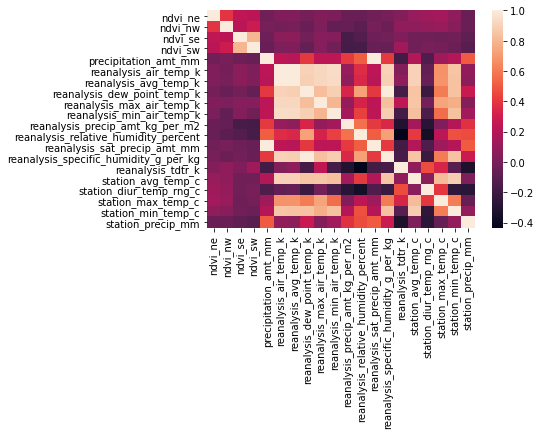

In [8]:
cor_mat = df.corr()
sns.heatmap(cor_mat)

# PCA
Normalize the data and apply find best principal components.

In [9]:
# Other scalers can be used
scaler = sklearn.preprocessing.StandardScaler()
X = scaler.fit_transform(df)

In [10]:
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(X)
X_pca.shape

(364, 20)

In [11]:
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

[8.35552297e+00 3.36228510e+00 2.04042409e+00 1.57496014e+00
 1.13339565e+00 6.97789533e-01 6.53465393e-01 5.65216654e-01
 5.60319685e-01 3.87358997e-01 2.52572657e-01 1.81622212e-01
 1.41089977e-01 6.95739822e-02 4.48220257e-02 3.10063772e-02
 2.57661050e-03 1.01296500e-03 8.13894067e-05 2.79289361e-33]
[4.16628412e-01 1.67652403e-01 1.01740927e-01 7.85316665e-02
 5.65140964e-02 3.47936264e-02 3.25835079e-02 2.81831931e-02
 2.79390173e-02 1.93147412e-02 1.25939388e-02 9.05616247e-03
 7.03511838e-03 3.46914225e-03 2.23494441e-03 1.54605974e-03
 1.28476595e-04 5.05091064e-05 4.05829047e-06 1.39261041e-34]
[0.41662841 0.58428081 0.68602174 0.76455341 0.8210675  0.85586113
 0.88844464 0.91662783 0.94456685 0.96388159 0.97647553 0.98553169
 0.99256681 0.99603595 0.9982709  0.99981696 0.99994543 0.99999594
 1.         1.        ]


## Explained Variance Ratio Distribution

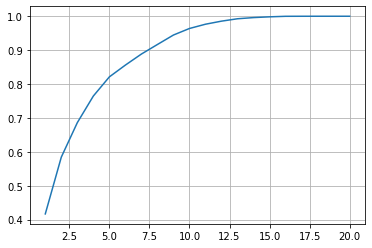

In [12]:

exp_cum_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(
    range(1, exp_cum_var.shape[0] + 1),
    exp_cum_var#,
    #labels={"x": "# Components", "y": "Explained Variance"}
)
plt.grid()

In [19]:
X_pca.shape, X.shape

((364, 20), (364, 20))

# Outlier identification
DBSCAN

In [16]:
import sklearn.metrics

matsim = sklearn.metrics.pairwise_distances(X_pca)

In [17]:
import plotly.express as px

fig = px.imshow(matsim)
fig.show()

In [35]:
from sklearn.neighbors import kneighbors_graph

minPts=3

In [36]:
A = kneighbors_graph(X_pca, minPts, include_self=False)
Ar = A.toarray()

In [27]:
seq = []
for i in range(len(X_pca)): #enumerate(X_pca):
    for j in range(len(X_pca)):
        if Ar[i][j] != 0:
            seq.append(matsim[i][j])
            
seq.sort()

In [28]:
fig = px.line(x=np.arange(0, len(seq), 1), y=seq)
fig.show()

In [15]:
from sklearn.cluster import DBSCAN

In [49]:
results = []
for eps in np.arange(1.2, 5.0, 0.2):
    db = DBSCAN(eps, min_samples=minPts).fit(X_pca)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_outliers = list(labels).count(-1)
    results.append([eps, n_clusters_, n_outliers])
pd.DataFrame(results, columns=['eps','clusters','outliers'])

,eps,clusters,outliers
0,1.2,0,364
1,1.4,1,360
2,1.6,4,346
3,1.8,8,297
4,2.0,5,252
5,2.2,5,180
6,2.4,3,134
7,2.6,2,91
8,2.8,2,58
9,3.0,1,37


### Visualize Data

In [70]:
db = DBSCAN(eps=2.2, min_samples=minPts).fit(X_pca)

In [71]:
X_v = PCA(2).fit_transform(X_pca)

In [72]:
px.scatter(x=X_v[:,0], y=X_v[:,1], color=db.labels_)

# Clustering
## K-means

## Hierarchical